In [12]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
sys.path.append("../")

In [14]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

In [15]:
from utils import create_mask as cm
from simulations.wrapper import simulator
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF
from utils.templates import get_NFW2_template
from sbi import utils
from operator import itemgetter

## Test embedding net

In [16]:
r_outer = 25

In [17]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [18]:
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = r_outer)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [19]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")

In [20]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [71]:
# Load templates

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

# temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
# temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

# Load Model A templates
temp_mA_pibrem = hp.ud_grade(np.load('../data/external/template_Api.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/external/template_Aic.npy'), nside_out=128, power=-2)

# Load Model F templates
temp_mF_pibrem = hp.ud_grade(np.load('../data/external/template_Fpi.npy'), nside_out=128, power=-2)
temp_mF_ics = hp.ud_grade(np.load('../data/external/template_Fic.npy'), nside_out=128, power=-2)

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer, custom_mask=ps_mask)
roi_mask_norm = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer)

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colorm

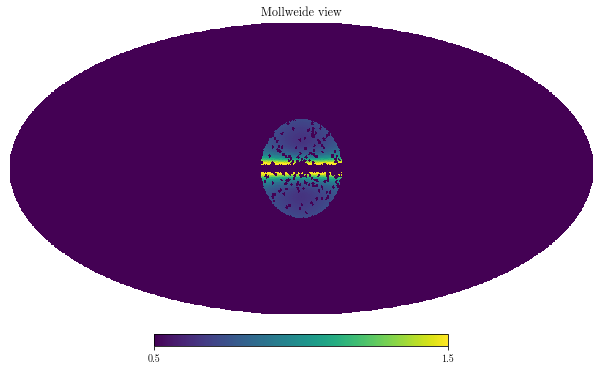

In [87]:
temp_dsk_new = hp.ud_grade(np.load('../data/external/template_disk_r_s_5_z_s_0.3.npy'), nside_out=128, power=-2)
temp_dsk_old = hp.ud_grade(np.load('../data/external/template_disk_r_s_5_z_s_1.npy'), nside_out=128, power=-2)
hp.mollview(~roi_mask * (temp_dsk_new / temp_dsk_old), max=1.5, min=0.5)

In [23]:
n_samples = 5

In [24]:
def save_files(data_map, aux, theta, sample_name):
    np.save("../data/samples/x_{}.npy".format(sample_name), data_map)
    np.save("../data/samples/x_aux_{}.npy".format(sample_name), aux)
    np.save("../data/samples/theta_{}.npy".format(sample_name), theta)

## Model O

### PS only

In [ ]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[1.5, 10.0, 1.8, -10.0, 5.0, 2., 0.47957617, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606], [1.5, 20.0, 1.99, -9.99, 10.0, 2., 0.47957617, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.000] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

In [ ]:
save_files(data_map, aux, thetas, "ModelO_PS_only")

### DM only

In [365]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[0., 10.0, 1.1, -10.0, 10.0, 0.1, 0.47957617, 15.288367  ,  1.6130469 , -4.5172763 , 23.960373  ,  2.4449606], [1e-5, 20.0, 1.99, -9.99, 25.0, 4.99, 0.47957617, 15.288367  ,  1.6130469 , -4.5172763 , 23.960373  ,  2.4449606]]

prior = utils.BoxUniform(low=torch.tensor([1.5] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.5] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

In [366]:
save_files(data_map, aux, thetas, "ModelO_DM_only")

## Model A

### PS only

In [106]:
# iso, bub, psc, dif
prior_poiss = [[1.2, 0.18, 0.5, 7., 3.4], [0.9, 0.18, 0.5, 7., 3.4]]

# gce, dsk
prior_ps = [[0.8, 15.0733,
          1.55, -3.5586,  9.0211,  2.4566, 0.3, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606], [0.8, 15.0733,
          1.55, -3.5586,  9.0211,  2.4566, 0.3, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606]]

prior = utils.BoxUniform(low=torch.tensor([0.4] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.4] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

In [107]:
torch.max(data_map[:,0,:], axis=1)

torch.return_types.max(
values=tensor([76., 66., 72., 79., 69.]),
indices=tensor([9005, 7376, 7274, 7374, 7374]))

In [108]:
save_files(data_map, aux, thetas, "ModelA_PS_only")

### DM only

In [22]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[0., 10.0, 1.1, -10.0, 10.0, 0.1, 0.47957617, 15.288367  ,  1.6130469 , -4.5172763 , 23.960373  ,  2.4449606], [1e-5, 20.0, 1.99, -9.99, 25.0, 4.99, 0.47957617, 15.288367  ,  1.6130469 , -4.5172763 , 23.960373  ,  2.4449606]]

prior = utils.BoxUniform(low=torch.tensor([1.5] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.5] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
save_files(data_map, aux, thetas, "ModelA_DM_only")

## Mismodeling

In [21]:
nside = 128

mO_mismo = np.load("../../fermi-gce-gp/data/mO_mismo.npy")
mismo_func = np.zeros(hp.nside2npix(nside))
mismo_func[~roi_mask] = mO_mismo

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colorm

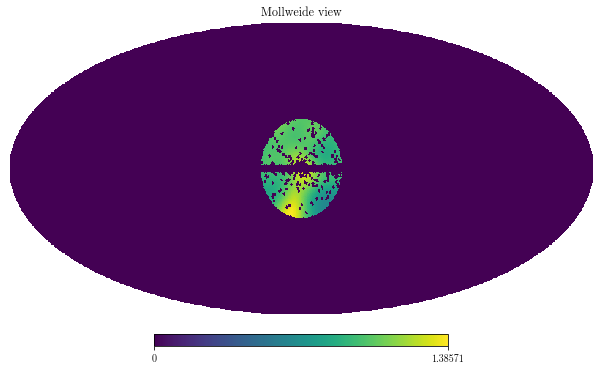

In [22]:
hp.mollview(~roi_mask * mismo_func)

In [25]:
temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, mismo_func * temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

In [26]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[1.5, 10.0, 1.8, -10.0, 5.0, 2., 0.47957617, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606], [1.5, 20.0, 1.99, -9.99, 10.0, 2., 0.47957617, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.000] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
save_files(data_map, aux, thetas, "ModelO_PS_only_mismo")

In [29]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.8, -10.0, 5.0, 2., 0.47957617, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606], [0.001, 20.0, 1.99, -9.99, 10.0, 2., 0.47957617, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606]]

prior = utils.BoxUniform(low=torch.tensor([1.5] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.5] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
save_files(data_map, aux, thetas, "ModelO_DM_only_mismo")

In [342]:
roi_mask_reduced = hp.reorder(cm.make_mask_total(nside=128, band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=15, custom_mask=ps_mask), r2n=True)

In [343]:
from utils.utils import ring2nest
data_map_nest = torch.Tensor(ring2nest(np.load("../data/samples/x_ModelO_PS_only.npy")[:, 0, :], masks_list[0])).unsqueeze(1)

tensor(44808.)

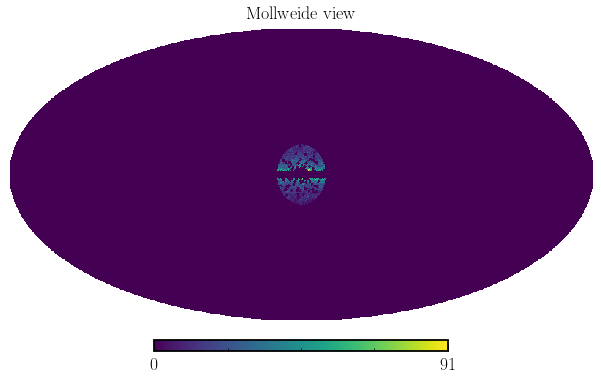

In [344]:
mask_large_roi = hp.reorder(masks_list[0], r2n=True)

indices_mask_reduced = np.intersect1d(np.where(~mask_large_roi == 1), np.where(~roi_mask_reduced == 1), return_indices=True)[1]

a = indices_mask_reduced
b = np.arange(np.sum(~mask_large_roi == 1))
c = torch.Tensor(np.setdiff1d(np.union1d(a, b), np.intersect1d(a, b))).type(torch.int64)

data_map_nest[:, :, c] = 0.

the_map = np.zeros(hp.nside2npix(128))
the_map[~mask_large_roi] = data_map_nest[0, 0]

hp.mollview(the_map, nest=True)
torch.sum(data_map_nest[0,0])

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  after removing the cwd from sys.path.
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  """
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated si

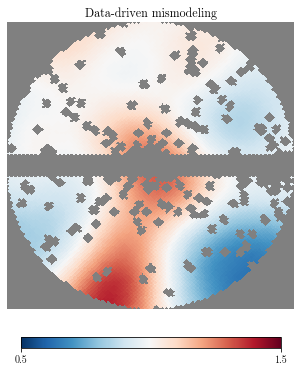

In [128]:
from pylab import arange, show, cm

cmap = cm.RdBu_r
cmap.set_under('w')
cmap.set_bad('w')

m = hp.ma(mismo_func)
m.mask = roi_mask

hp.cartview(m, min=0.5, max=1.5, lonra=[-25, 25], latra=[-25, 25], return_projected_map=True, cmap=cmap, title="Data-driven mismodeling");
rpm.mask = (rpm.data == 0)

In [138]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

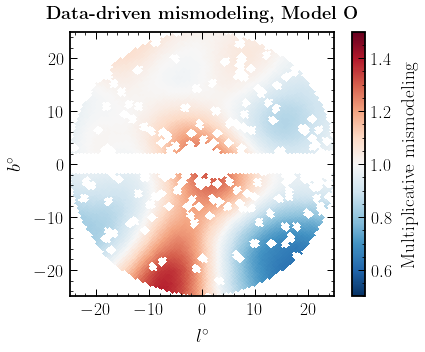

In [155]:
cmap = cm.RdBu_r

plt.imshow(rpm, cmap=cmap, origin='lower', vmin=0.5, vmax=1.5, extent=[-25, 25, -25, 25])
plt.colorbar(label="Multiplicative mismodeling")
plt.xlabel("$l^\circ$")
plt.ylabel("$b^\circ$")
plt.title(r"\textbf{Data-driven mismodeling, Model O}", y=1.02)
plt.tight_layout()
plt.savefig("../paper/plots/dd_mismo_map.pdf")

## Asymmetric DM

In [42]:
roi_mask_N = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, b_mask=True, b_deg_min=0, mask_ring=True, inner=0, outer=r_outer)
roi_mask_S = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, b_mask=True, b_deg_max=0, mask_ring=True, inner=0, outer=r_outer)

In [43]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.8, -10.0, 5.0, 2., 0.47957617, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606], [0.001, 20.0, 1.99, -9.99, 10.0, 2., 0.47957617, 15.288367  ,  1.6130469 ,
        -4.5172763 , 12.960373  ,  2.4449606]]

prior = utils.BoxUniform(low=torch.tensor([0.5, 1.5] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.5, 1.5] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce * roi_mask_N, temp_gce * roi_mask_S, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/5 [00:00<?, ?it/s]

In [44]:
save_files(data_map, aux, thetas, "ModelO_DM_asym")